In [2]:
# Random Forest Classification Script for Recipe Reviews Dataset
# Implements data exploration, preprocessing, hyperparameter tuning, and evaluation
# Includes outlier handling, feature importance, holdout vs. CV comparison, parameter sensitivity,
# preprocessing strategy comparison, runtime analysis, report-ready summaries, and trend identification

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import time
import os
%matplotlib inline


Dataset Shape: (18182, 15)

First 5 Rows:
    Unnamed: 0  recipe_number  recipe_code         recipe_name  \
0           0              1        14299  Creamy White Chili   
1           1              1        14299  Creamy White Chili   
2           2              1        14299  Creamy White Chili   
3           3              1        14299  Creamy White Chili   
4           4              1        14299  Creamy White Chili   

                                        comment_id         user_id  \
0  sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM  u_9iFLIhMa8QaG   
1  sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY  u_Lu6p25tmE77j   
2  sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP  u_s0LwgpZ8Jsqq   
3  sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC  u_fqrybAdYjgjG   
4  sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI  u_XXWKwVhKZD69   

    user_name  user_reputation  created_at  reply_count  thumbs_up  \
0     Jeri326                1  1665619889            0          0   
1   

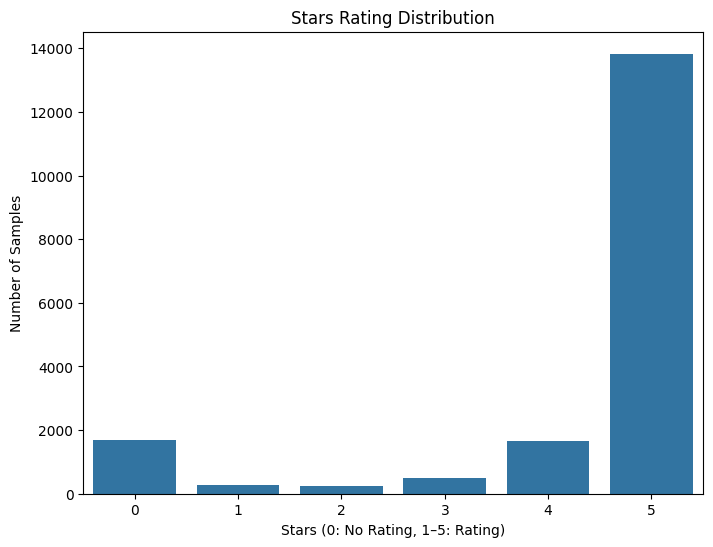


Missing Values:
 text    2
dtype: int64

Columns with value 2 (potential missing values):
 Unnamed: 0         100
recipe_number      509
recipe_code          0
recipe_name          0
comment_id           0
user_id              0
user_name            0
user_reputation      0
created_at           0
reply_count         24
thumbs_up          624
thumbs_down        388
stars              232
best_score           0
text                 0
dtype: int64

Feature Statistics (Numerical):
          Unnamed: 0  recipe_number    recipe_code  user_reputation  \
count  18182.000000   18182.000000   18182.000000     18182.000000   
mean     121.465295      38.689363   21773.667253         2.159608   
std      116.747893      29.786647   23965.109637        10.014666   
min        0.000000       1.000000     386.000000         0.000000   
25%       45.000000      12.000000    6086.000000         1.000000   
50%       91.000000      33.000000   14600.000000         1.000000   
75%      150.000000      6

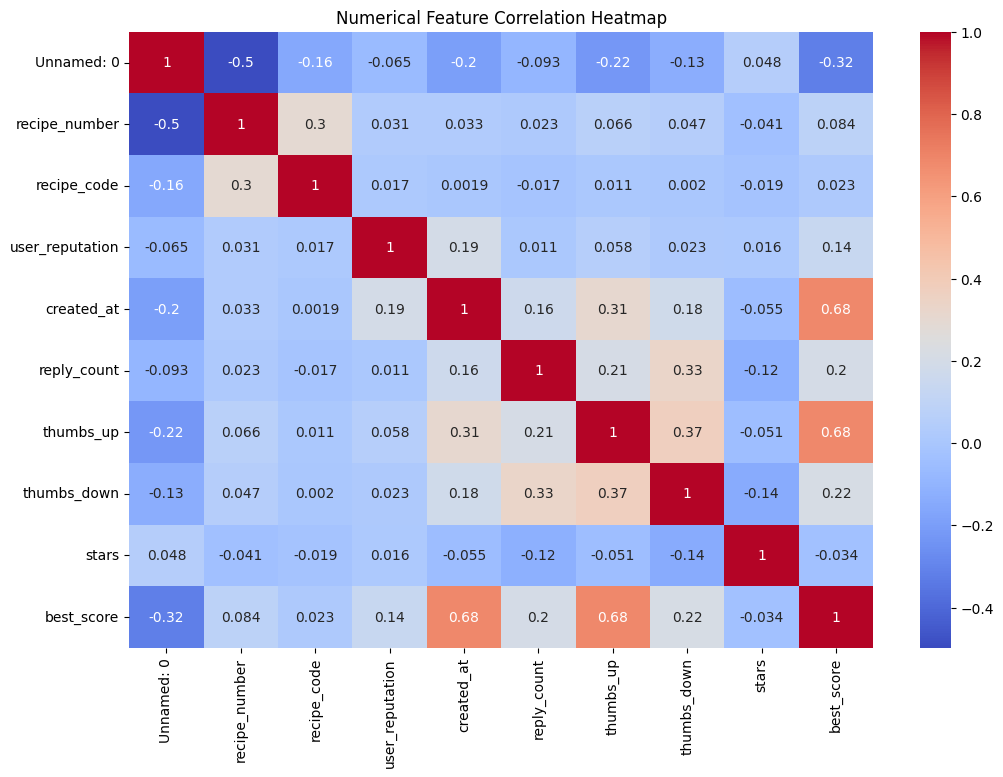


Outlier Analysis:
Unnamed: 0: 1383 outliers


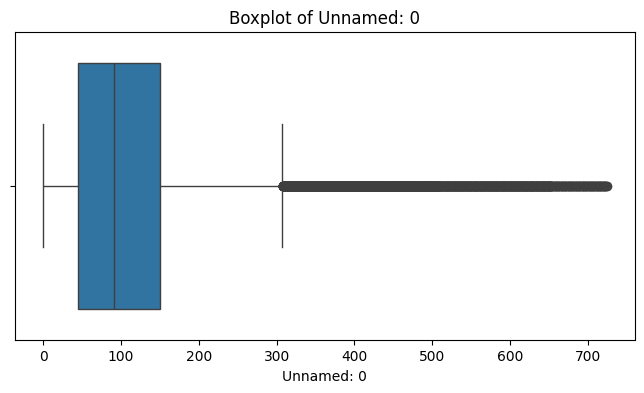

recipe_number: 0 outliers


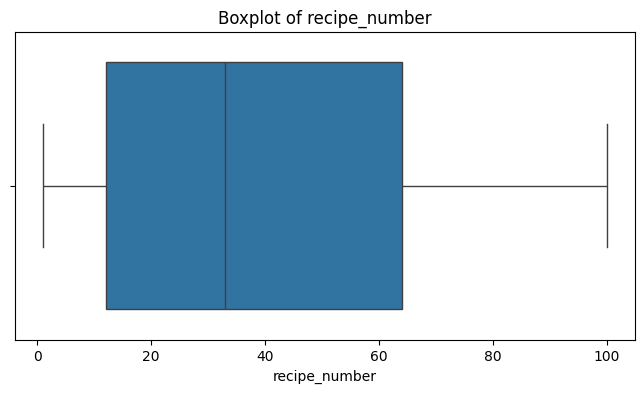

recipe_code: 656 outliers


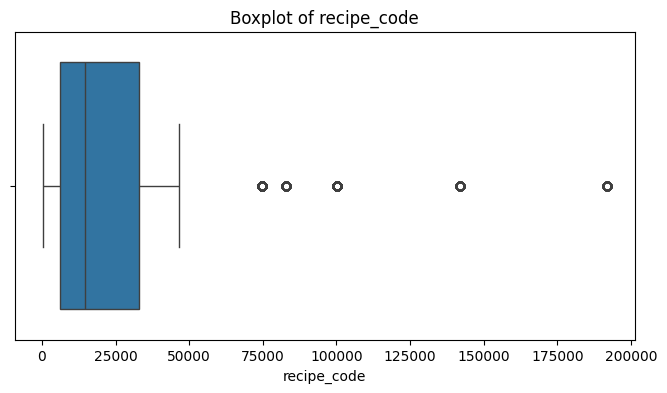

user_reputation: 1246 outliers


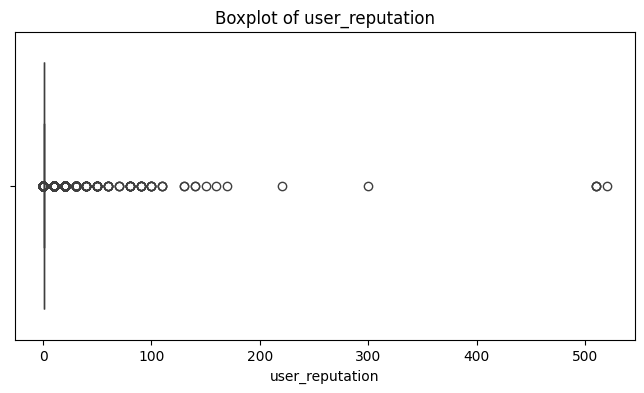

created_at: 1487 outliers


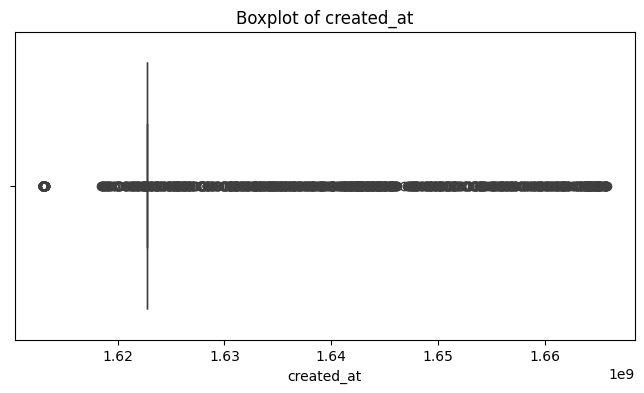

reply_count: 230 outliers


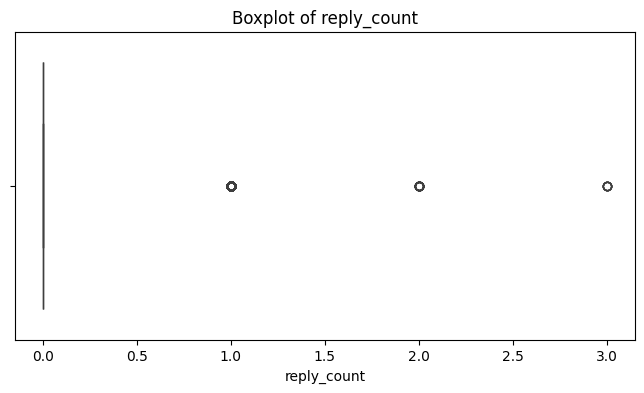

thumbs_up: 4080 outliers


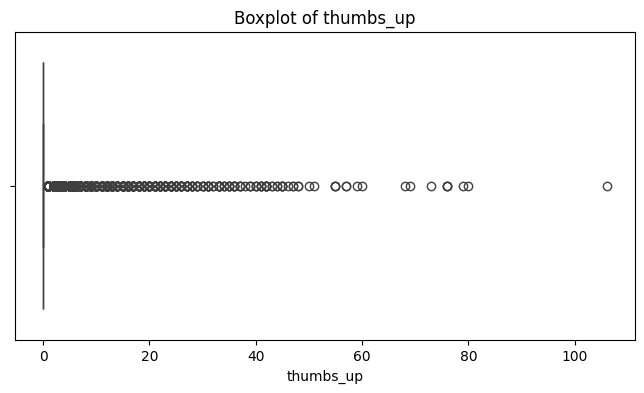

thumbs_down: 2396 outliers


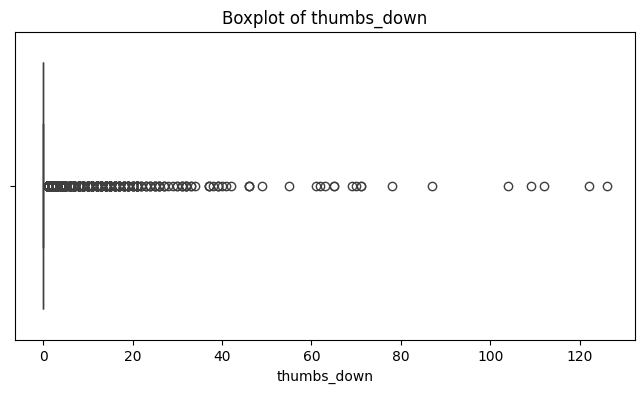

stars: 4353 outliers


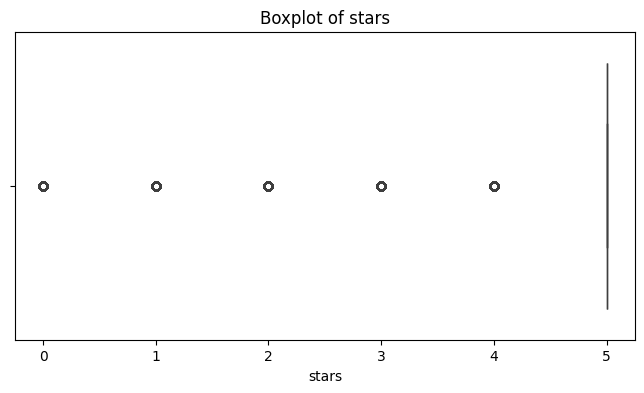

best_score: 4180 outliers


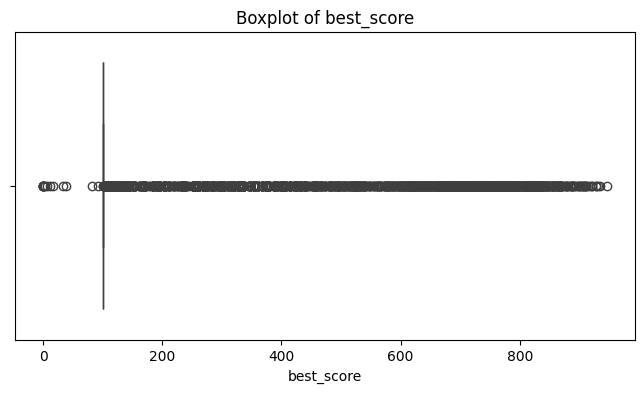

In [ ]:
# Cell 2: Data Exploration
def detect_outliers(df, numerical_cols):
    """Detect and visualize outliers using IQR method for numerical features."""
    print("\nOutlier Analysis:")
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"{col}: {len(outliers)} outliers")
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.savefig(f'outliers_{col}_recipe.png')
        plt.show()

def explore_dataset(df):
    """Explore dataset structure, class distribution, missing values, and outliers.
    Saves visualizations (class distribution, correlation heatmap, boxplots) for the report.
    """
    print("\nDataset Shape:", df.shape)
    print("\nFirst 5 Rows:\n", df.head())
    print("\nData Types:\n", df.dtypes)
    
    # Class distribution
    class_counts = df['stars'].value_counts()
    print("\nClass Distribution (Stars):\n", class_counts)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Stars Rating Distribution')
    plt.xlabel('Stars (0: No Rating, 1–5: Rating)')
    plt.ylabel('Number of Samples')
    plt.savefig('class_distribution_recipe.png')
    plt.show()
    
    # Missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:\n", missing_values[missing_values > 0])
    
    # Check for special missing value indicator (2)
    print("\nColumns with value 2 (potential missing values):\n", (df == 2).sum())
    
    # Feature statistics (numerical features only)
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    print("\nFeature Statistics (Numerical):\n", df[numerical_cols].describe())
    
    # Feature correlations (numerical features)
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols].corr(), cmap='coolwarm', annot=True)
    plt.title('Numerical Feature Correlation Heatmap')
    plt.savefig('feature_correlation_recipe.png')
    plt.show()
    
    # Outlier detection
    detect_outliers(df, numerical_cols)

# Load dataset with error handling
data_path = 'Recipe Reviews and User Feedback Dataset.csv'  
try:
    df = pd.read_csv(data_path)
    if 'stars' not in df.columns:
        raise ValueError("Dataset must contain 'stars' column")
except FileNotFoundError:
    print(f"Error: File {data_path} not found")
    exit(1)
except Exception as e:
    print(f"Error loading data: {e}")
    exit(1)

# Explore dataset
explore_dataset(df)

In [4]:
# Cell 3: Preprocessing
def preprocess_data(df, scaling=True, imputation_strategy='median', sample_fraction=1.0):
    """Preprocess the dataset: sample, handle missing values, encode features, scale, split data.
    Args:
        df: Input DataFrame
        scaling: Whether to apply StandardScaler (True) or not (False)
        imputation_strategy: Strategy for numerical imputation ('median' or 'mean')
        sample_fraction: Fraction of data to sample (e.g., 0.5 for 50%)
    Returns:
        X_train, X_test, y_train, y_test, y, feature_cols
    """
    # Subsample dataset
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    
    # Drop text and non-predictive ID columns
    drop_cols = ['text', 'comment_id', 'user_id', 'user_name']
    sampled_df = sampled_df.drop(columns=drop_cols)
    
    # Replace special missing value indicator (2) with NaN
    sampled_df = sampled_df.replace(2, np.nan)
    
    # Drop rows where target 'stars' is NaN
    sampled_df = sampled_df.dropna(subset=['stars'])
    
    # Separate features and target
    feature_cols = [col for col in sampled_df.columns if col != 'stars']
    X = sampled_df[feature_cols]
    y = sampled_df['stars']
    
    # Handle categorical features
    categorical_cols = X.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # Impute missing values for numerical features
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    if len(numerical_cols) > 0:
        num_imputer = SimpleImputer(strategy=imputation_strategy)
        X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
    
    # Scale numerical features if specified
    if scaling:
        scaler = StandardScaler()
        X_processed = scaler.fit_transform(X)
    else:
        X_processed = X.values
    
    # Split data (80% train, 20% test, stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nDataset size: {sampled_df.shape[0]}, Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test, y, feature_cols

In [5]:
# Cell 4: Random Forest Experiments
def run_rf_experiments(X_train, y_train, X_test, y_test, class_names, feature_cols):
    """Run Random Forest experiments with different parameter settings.
    Args:
        X_train, y_train, X_test, y_test: Training and testing data
        class_names: List of class names for visualization
        feature_cols: List of feature column names
    Returns:
        List of results dictionaries
    """
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2]
    }
    
    # Initialize results storage
    results = []
    
    # Experiment with parameter settings
    print("\n=== Random Forest Experiments ===")
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for max_features in param_grid['max_features']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        print(f"\nTesting: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, max_features={max_features}, min_samples_leaf={min_samples_leaf}")
                        
                        # Initialize classifier with balanced class weights to handle potential imbalance
                        rf_classifier = RandomForestClassifier(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42,
                            class_weight='balanced'
                        )
                        
                        # Measure training time
                        start_time = time.time()
                        rf_classifier.fit(X_train, y_train)
                        training_time = time.time() - start_time
                        
                        # Holdout evaluation
                        start_time = time.time()
                        predictions = rf_classifier.predict(X_test)
                        prediction_time = time.time() - start_time
                        
                        # Performance metrics
                        accuracy = accuracy_score(y_test, predictions)
                        f1 = f1_score(y_test, predictions, average='weighted')
                        roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test), multi_class='ovr')
                        
                        # Cross-validation (5-fold)
                        cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
                        cv_accuracy = np.mean(cv_scores)
                        
                        # Store results
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'max_features': max_features,
                            'min_samples_leaf': min_samples_leaf,
                            'accuracy': accuracy,
                            'f1_score': f1,
                            'roc_auc': roc_auc,
                            'cv_accuracy': cv_accuracy,
                            'training_time': training_time,
                            'prediction_time': prediction_time
                        })
                        
                        # Print results
                        print(f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}, CV Accuracy: {cv_accuracy:.2f}")
                        print(f"Training Time: {training_time:.2f}s, Prediction Time: {prediction_time:.2f}s")
    
    return results

In [6]:
# Cell 5: Visualization and Analysis
def plot_feature_importance(model, feature_cols):
    """Plot feature importances of the Random Forest model."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_cols[i] for i in indices], rotation=45)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('rf_feature_importance_recipe.png')
    plt.show()

def compare_holdout_cv(results_df):
    """Compare holdout and cross-validation accuracies."""
    results_df['holdout_cv_diff'] = results_df['accuracy'] - results_df['cv_accuracy']
    print("\nHoldout vs. CV Accuracy Difference:\n", results_df[['accuracy', 'cv_accuracy', 'holdout_cv_diff']].describe())
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=results_df, x='cv_accuracy', y='accuracy', hue='n_estimators')
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.title('Holdout vs. Cross-Validation Accuracy')
    plt.savefig('rf_holdout_vs_cv_recipe.png')
    plt.show()

def analyze_parameter_sensitivity(results_df):
    """Analyze sensitivity of accuracy to parameter settings."""
    print("\nParameter Sensitivity (Std of Accuracy):")
    for param in ['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf']:
        grouped = results_df.groupby(param)['accuracy'].std()
        print(f"{param}:\n{grouped}")

def summarize_best_models(results_df, top_n=5):
    """Summarize top N models by accuracy."""
    top_models = results_df.nlargest(top_n, 'accuracy')[['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf', 'accuracy', 'f1_score', 'roc_auc', 'cv_accuracy', 'training_time']]
    print("\nTop 5 Models:\n", top_models)
    top_models.to_csv('rf_top_models_recipe.csv', index=False)

def identify_trends(results_df):
    """Identify common parameter values in top 10 models."""
    print("\nMost Common Parameters in Top 10 Models:")
    top_10 = results_df.nlargest(10, 'accuracy')
    for param in ['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'min_samples_leaf']:
        print(f"{param}: {top_10[param].value_counts().head(1)}")

def visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names, feature_cols):
    """Visualize results, save to CSV, and generate report-ready summaries.
    Includes confusion matrix, classification report, parameter sensitivity, and feature importance.
    """
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:\n", results_df)
    
    # Additional analyses
    summarize_best_models(results_df)
    compare_holdout_cv(results_df)
    analyze_parameter_sensitivity(results_df)
    identify_trends(results_df)
    
    # Save results
    results_df.to_csv("rf_results_recipe.csv", index=False)
    
    # Find best model
    best_idx = results_df['accuracy'].idxmax()
    max_depth = results_df.loc[best_idx]['max_depth']
    max_depth = None if pd.isna(max_depth) else int(max_depth)
    
    best_rf = RandomForestClassifier(
        n_estimators=int(results_df.loc[best_idx]['n_estimators']),
        max_depth=max_depth,
        min_samples_split=int(results_df.loc[best_idx]['min_samples_split']),
        max_features=results_df.loc[best_idx]['max_features'],
        min_samples_leaf=int(results_df.loc[best_idx]['min_samples_leaf']),
        random_state=42,
        class_weight='balanced'
    )
    best_rf.fit(X_train, y_train)
    predictions = best_rf.predict(X_test)
    
    # Feature importance
    plot_feature_importance(best_rf, feature_cols)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Random Forest Confusion Matrix')
    plt.savefig('rf_confusion_matrix_recipe.png')
    plt.show()
    
    # Classification report
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, predictions, target_names=class_names))
    
    # Plot accuracy vs. n_estimators
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='n_estimators', y='accuracy', hue='max_depth', style='min_samples_split')
    plt.title('Accuracy vs. n_estimators')
    plt.savefig('rf_accuracy_vs_estimators_recipe.png')
    plt.show()
    
    # Plot accuracy vs. max_depth
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_depth', y='accuracy', hue='n_estimators', style='min_samples_split')
    plt.title('Accuracy vs. max_depth')
    plt.savefig('rf_accuracy_vs_max_depth_recipe.png')
    plt.show()
    
    # Plot accuracy vs. max_features
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_features', y='accuracy', hue='n_estimators', style='min_samples_leaf')
    plt.title('Accuracy vs. max_features')
    plt.savefig('rf_accuracy_vs_max_features_recipe.png')
    plt.show()

/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of 


Dataset size: 17950, Training samples: 14360, Testing samples: 3590
Class names: ['0 Stars', '1 Star', '3 Stars', '4 Stars', '5 Stars']

=== Experiments: Scaling=True, Imputation=median, Fraction=0.5 ===

Dataset size: 8988, Training samples: 7190, Testing samples: 1798

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.77, F1-Score: 0.71, ROC-AUC: 0.66, CV Accuracy: 0.76
Training Time: 1.93s, Prediction Time: 0.06s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.74, F1-Score: 0.70, ROC-AUC: 0.67, CV Accuracy: 0.73
Training Time: 1.39s, Prediction Time: 0.03s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.77, F1-Score: 0.71, ROC-AUC: 0.66, CV Accuracy: 0.76
Training Time: 1.49s, Prediction Time: 0.04s

Testing: n_estimators=50, max_depth=None, min_samples_sp

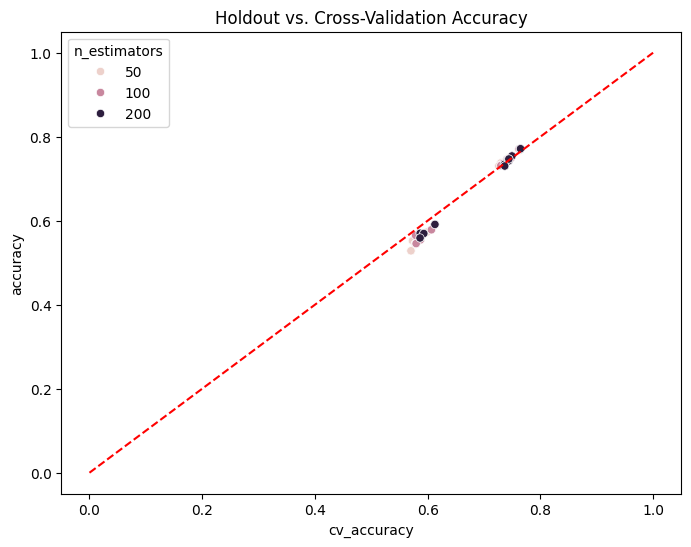


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.095697
100    0.091809
200    0.086206
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.016747
20.0    0.015370
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.088968
5    0.091752
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.090763
sqrt    0.090763
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.092222
2    0.088089
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    10
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    10
Name: count, dtype: int64


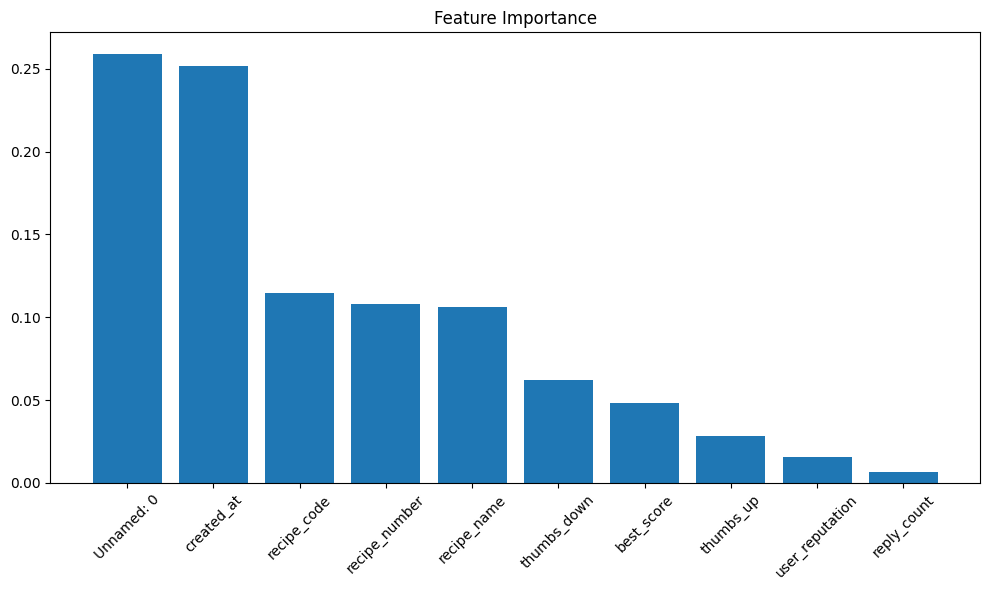

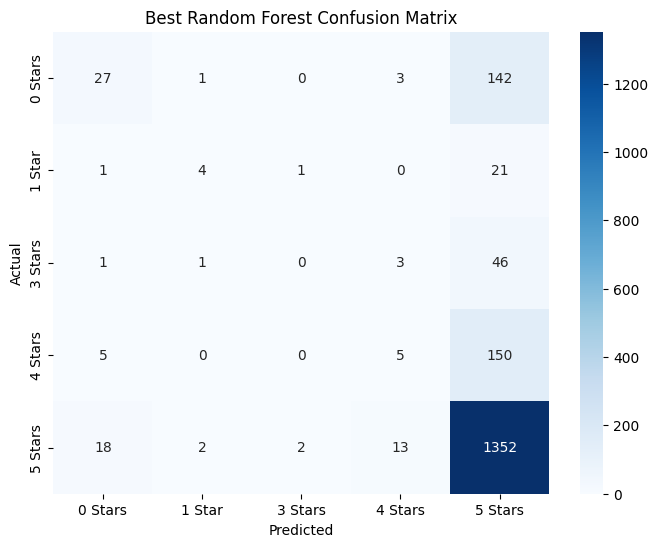


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.52      0.16      0.24       173
      1 Star       0.50      0.15      0.23        27
     3 Stars       0.00      0.00      0.00        51
     4 Stars       0.21      0.03      0.05       160
     5 Stars       0.79      0.97      0.87      1387

    accuracy                           0.77      1798
   macro avg       0.40      0.26      0.28      1798
weighted avg       0.69      0.77      0.70      1798



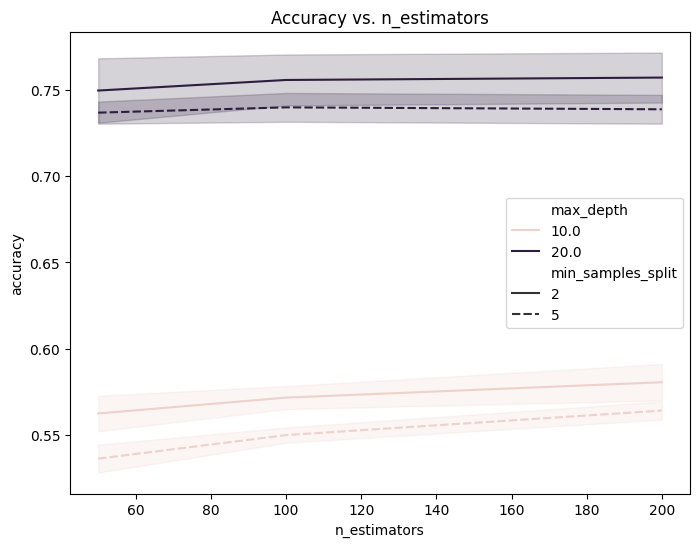

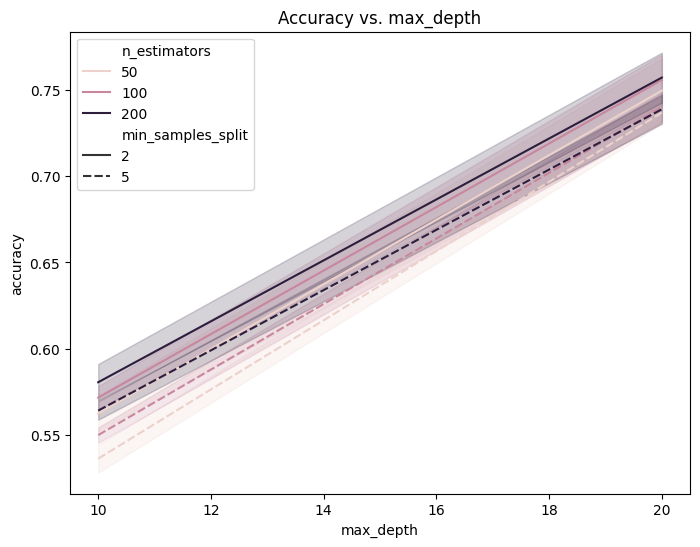

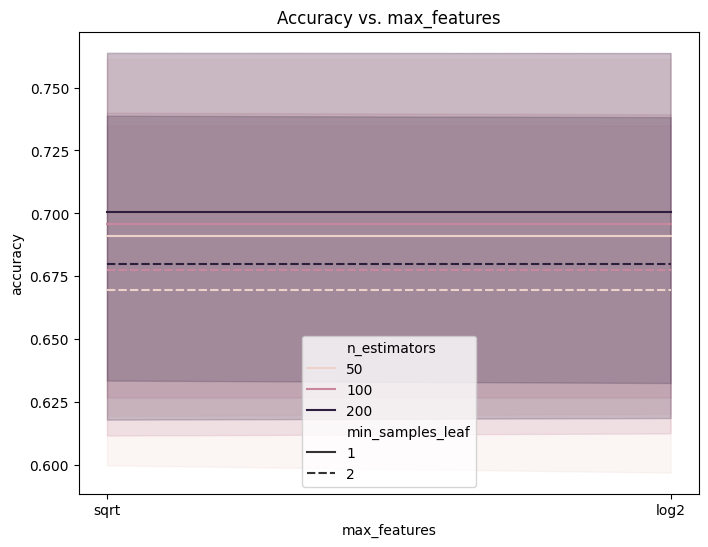


=== Experiments: Scaling=True, Imputation=median, Fraction=1.0 ===

Dataset size: 17950, Training samples: 14360, Testing samples: 3590

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])


Accuracy: 0.76, F1-Score: 0.71, ROC-AUC: 0.67, CV Accuracy: 0.77
Training Time: 2.33s, Prediction Time: 0.06s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.74, F1-Score: 0.71, ROC-AUC: 0.69, CV Accuracy: 0.74
Training Time: 1.43s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.76, F1-Score: 0.71, ROC-AUC: 0.67, CV Accuracy: 0.77
Training Time: 6.85s, Prediction Time: 0.22s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.74, F1-Score: 0.71, ROC-AUC: 0.69, CV Accuracy: 0.74
Training Time: 1.81s, Prediction Time: 0.06s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.74, F1-Score: 0.70, ROC-AUC: 0.67, CV Accuracy: 0.75
Training Time: 1.64s, Prediction Time: 0.04s

Testing: n_estimators=50, max_depth=None,

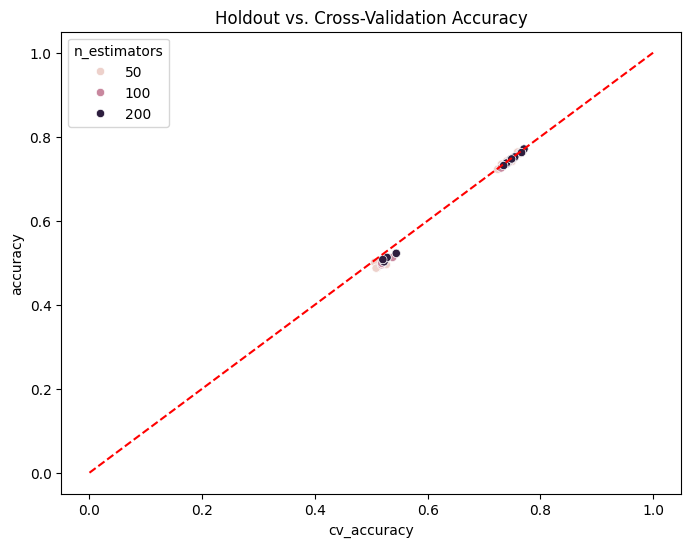


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.120645
100    0.117041
200    0.114627
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.010221
20.0    0.014288
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.119771
5    0.113347
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.116698
sqrt    0.116698
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.118664
2    0.113996
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
200    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    10
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    10
Name: count, dtype: int64


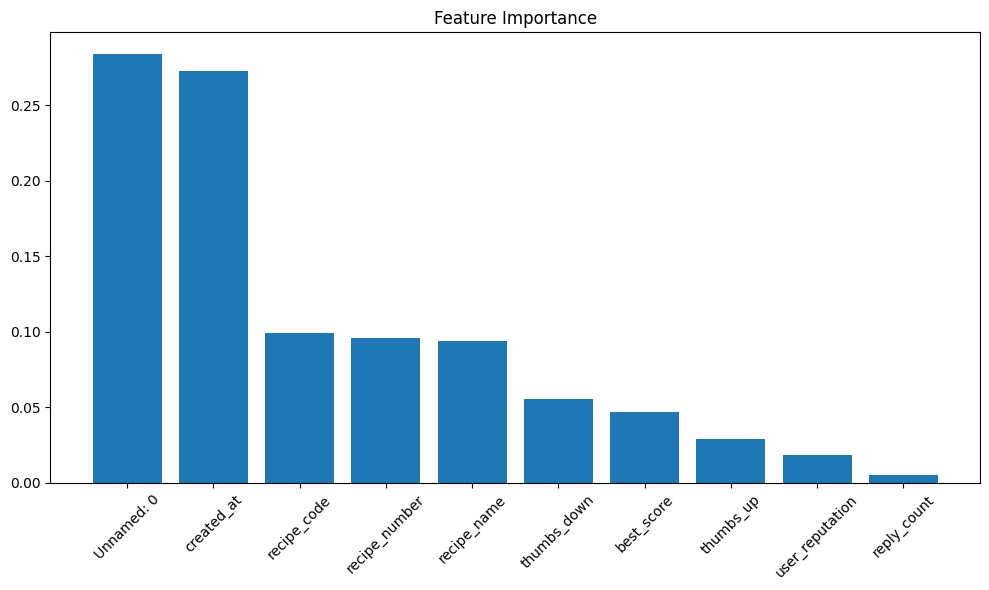

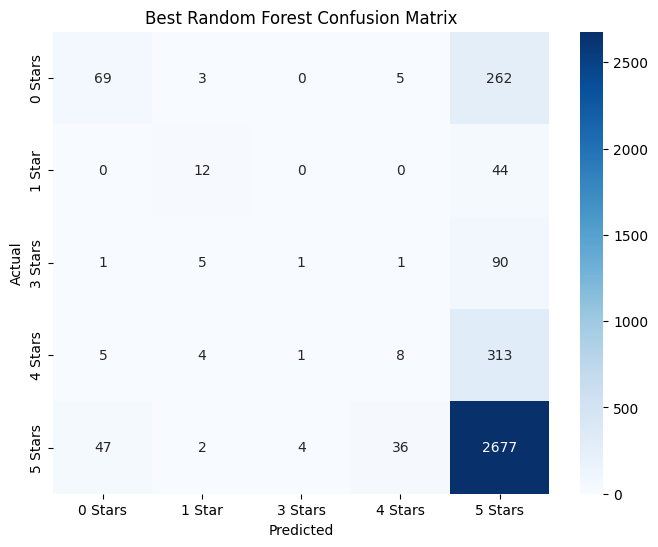


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.57      0.20      0.30       339
      1 Star       0.46      0.21      0.29        56
     3 Stars       0.17      0.01      0.02        98
     4 Stars       0.16      0.02      0.04       331
     5 Stars       0.79      0.97      0.87      2766

    accuracy                           0.77      3590
   macro avg       0.43      0.28      0.30      3590
weighted avg       0.69      0.77      0.71      3590



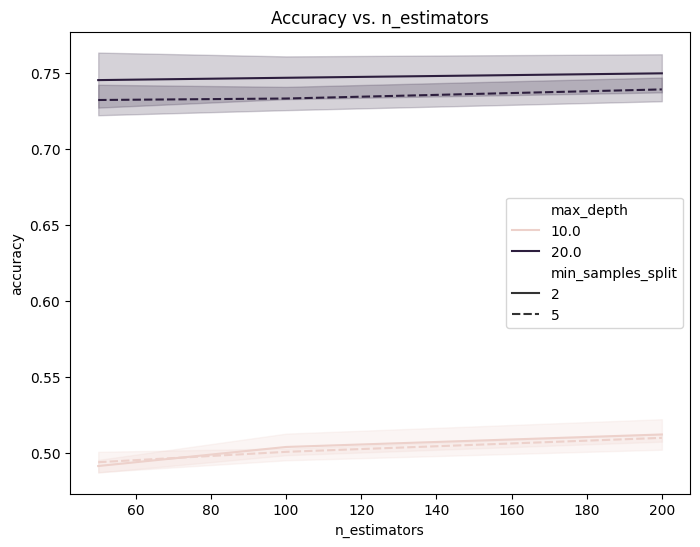

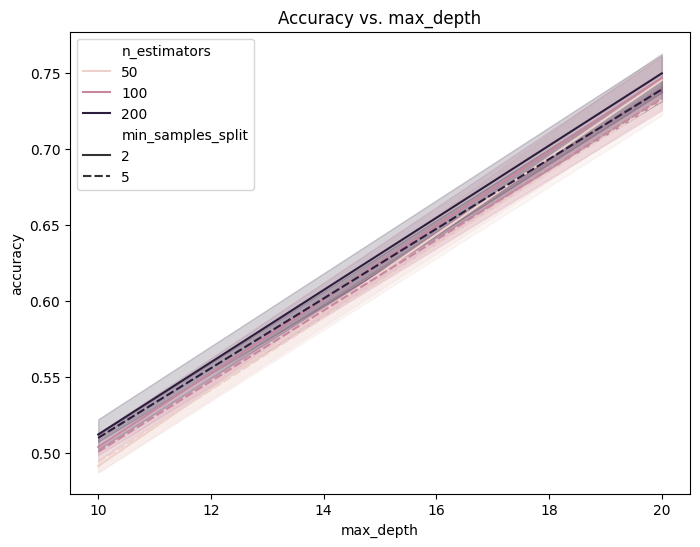

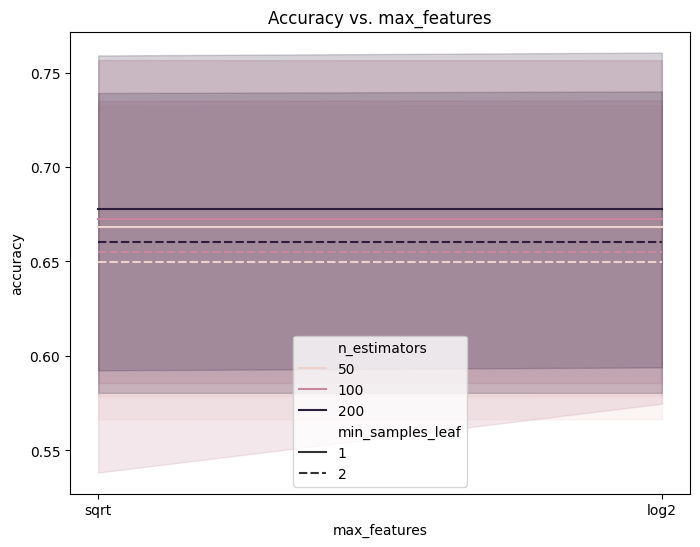


=== Experiments: Scaling=True, Imputation=mean, Fraction=0.5 ===

Dataset size: 8988, Training samples: 7190, Testing samples: 1798

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])


Accuracy: 0.77, F1-Score: 0.70, ROC-AUC: 0.65, CV Accuracy: 0.76
Training Time: 0.99s, Prediction Time: 0.03s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.74, F1-Score: 0.70, ROC-AUC: 0.66, CV Accuracy: 0.74
Training Time: 0.83s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.77, F1-Score: 0.70, ROC-AUC: 0.65, CV Accuracy: 0.76
Training Time: 0.77s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.74, F1-Score: 0.70, ROC-AUC: 0.66, CV Accuracy: 0.74
Training Time: 0.68s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.75, F1-Score: 0.70, ROC-AUC: 0.67, CV Accuracy: 0.74
Training Time: 0.72s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None,

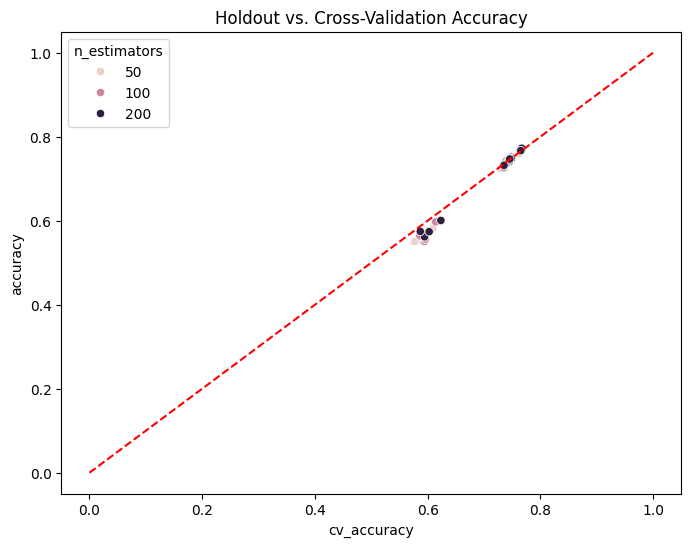


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.089568
100    0.088713
200    0.083330
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.017494
20.0    0.014726
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.087636
5    0.085303
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.086723
sqrt    0.086723
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.087313
2    0.084744
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
200    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    10
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    10
Name: count, dtype: int64


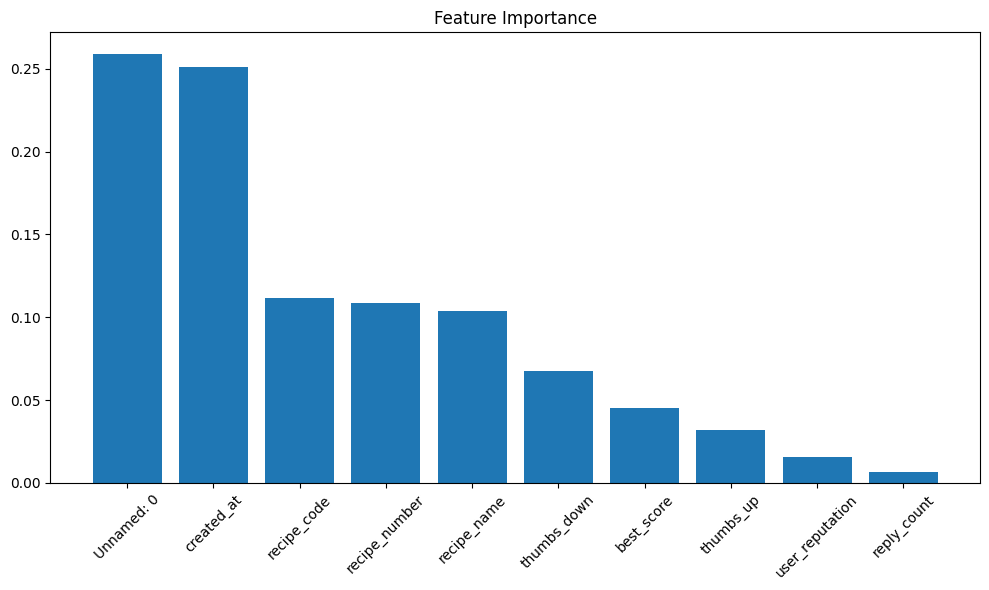

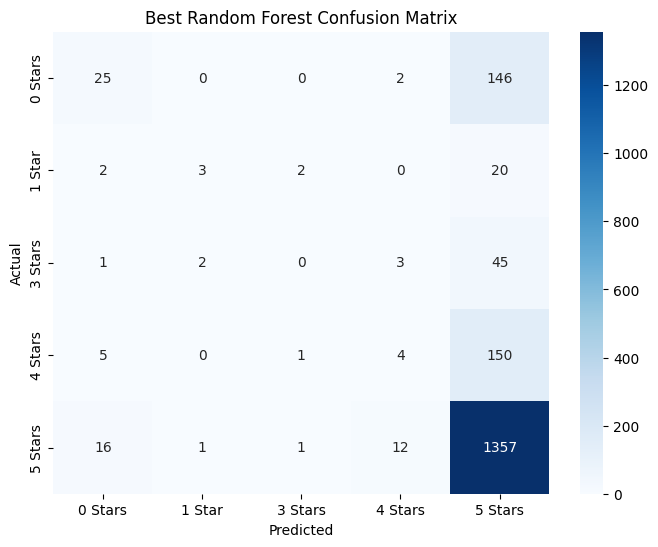


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.51      0.14      0.23       173
      1 Star       0.50      0.11      0.18        27
     3 Stars       0.00      0.00      0.00        51
     4 Stars       0.19      0.03      0.04       160
     5 Stars       0.79      0.98      0.87      1387

    accuracy                           0.77      1798
   macro avg       0.40      0.25      0.27      1798
weighted avg       0.68      0.77      0.70      1798



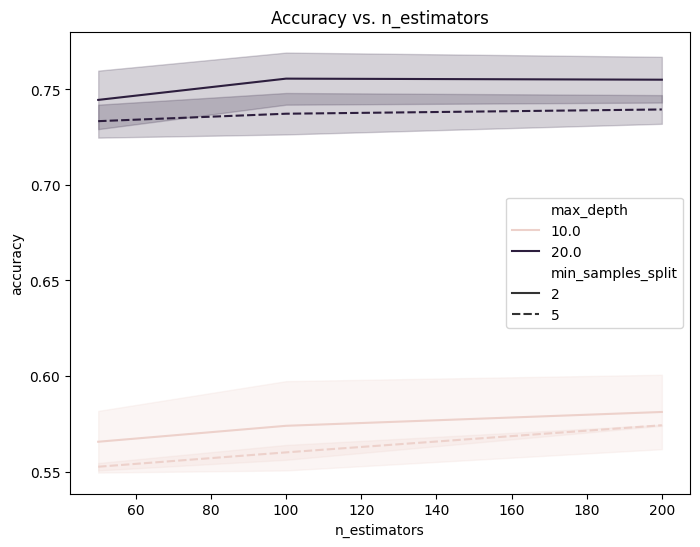

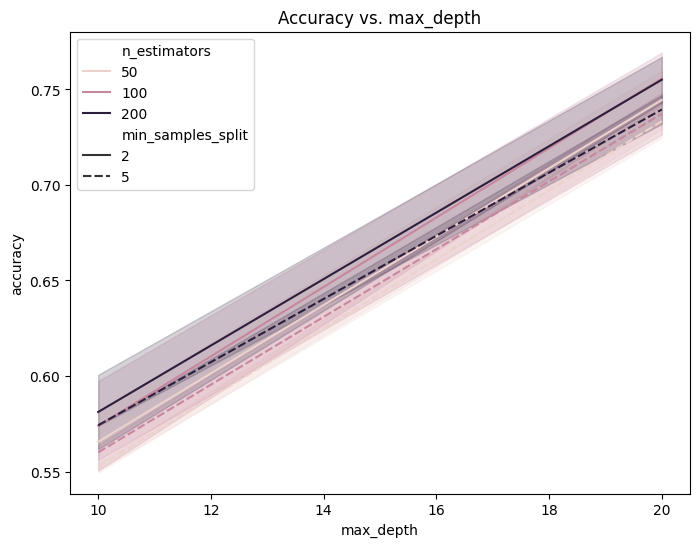

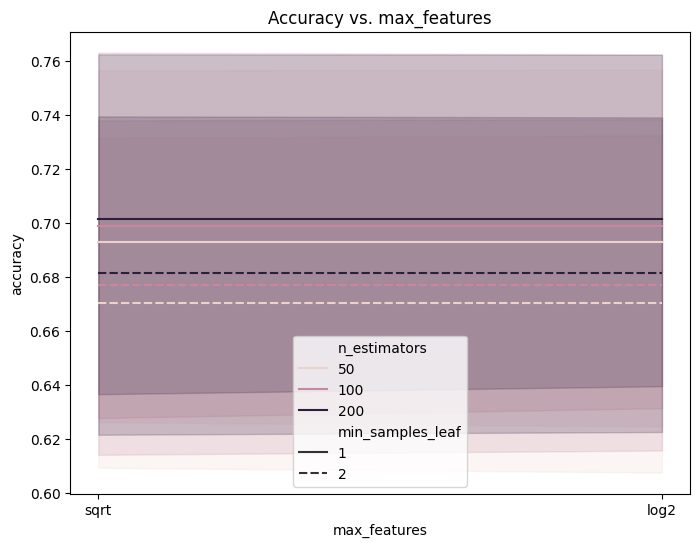


=== Experiments: Scaling=True, Imputation=mean, Fraction=1.0 ===

Dataset size: 17950, Training samples: 14360, Testing samples: 3590

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])


Accuracy: 0.77, F1-Score: 0.71, ROC-AUC: 0.68, CV Accuracy: 0.77
Training Time: 1.57s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.74, F1-Score: 0.71, ROC-AUC: 0.69, CV Accuracy: 0.74
Training Time: 1.43s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.77, F1-Score: 0.71, ROC-AUC: 0.68, CV Accuracy: 0.77
Training Time: 1.75s, Prediction Time: 0.06s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.74, F1-Score: 0.71, ROC-AUC: 0.69, CV Accuracy: 0.74
Training Time: 1.30s, Prediction Time: 0.04s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.75, F1-Score: 0.71, ROC-AUC: 0.67, CV Accuracy: 0.75
Training Time: 1.59s, Prediction Time: 0.07s

Testing: n_estimators=50, max_depth=None,

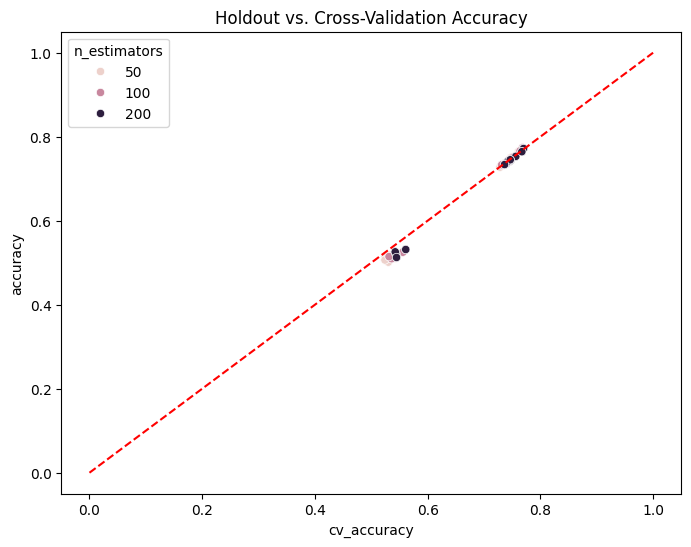


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.114464
100    0.111915
200    0.109374
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.008628
20.0    0.013454
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.112407
5    0.109657
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.111187
sqrt    0.111187
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.115456
2    0.106175
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    10
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    10
Name: count, dtype: int64


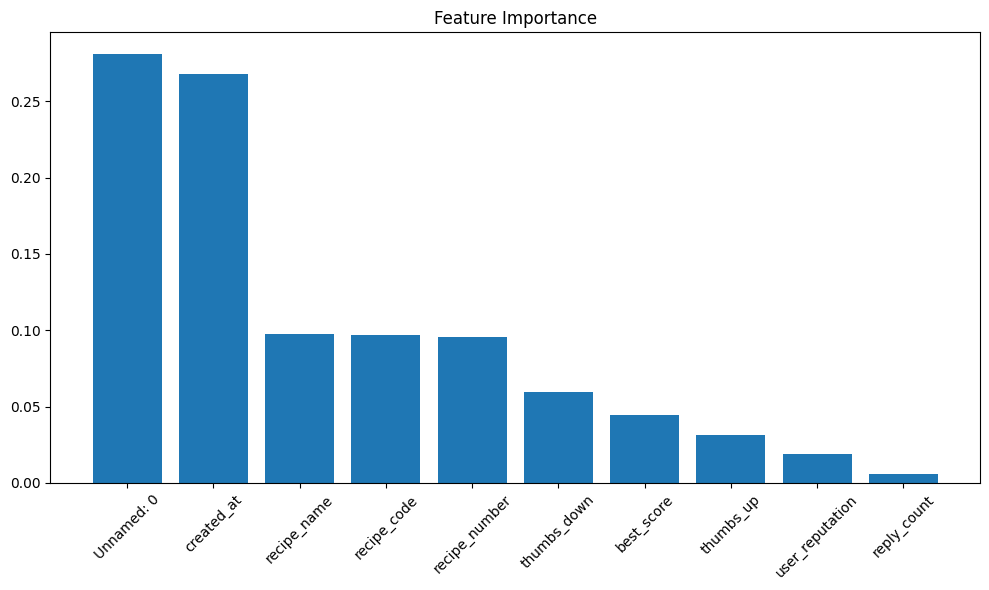

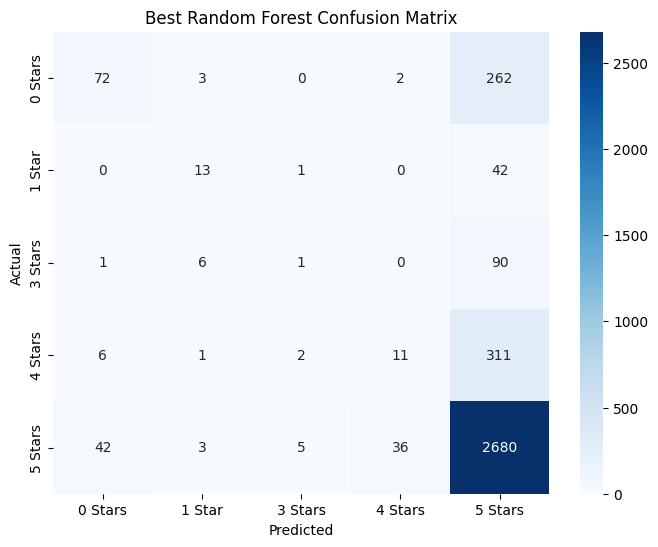


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.60      0.21      0.31       339
      1 Star       0.50      0.23      0.32        56
     3 Stars       0.11      0.01      0.02        98
     4 Stars       0.22      0.03      0.06       331
     5 Stars       0.79      0.97      0.87      2766

    accuracy                           0.77      3590
   macro avg       0.44      0.29      0.32      3590
weighted avg       0.70      0.77      0.71      3590



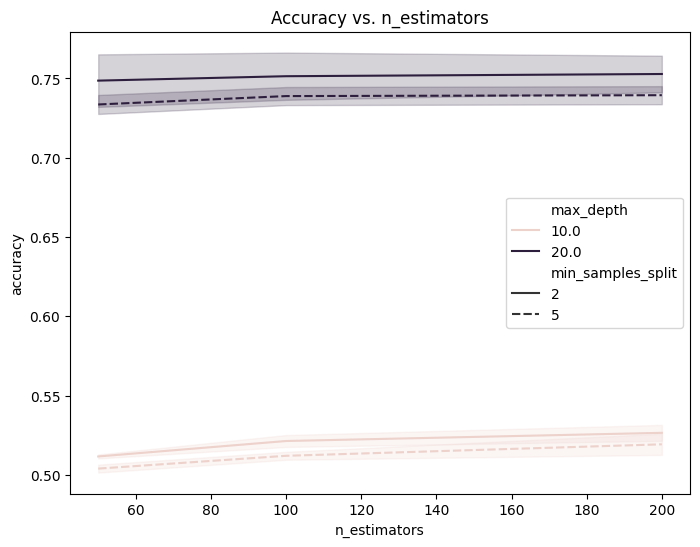

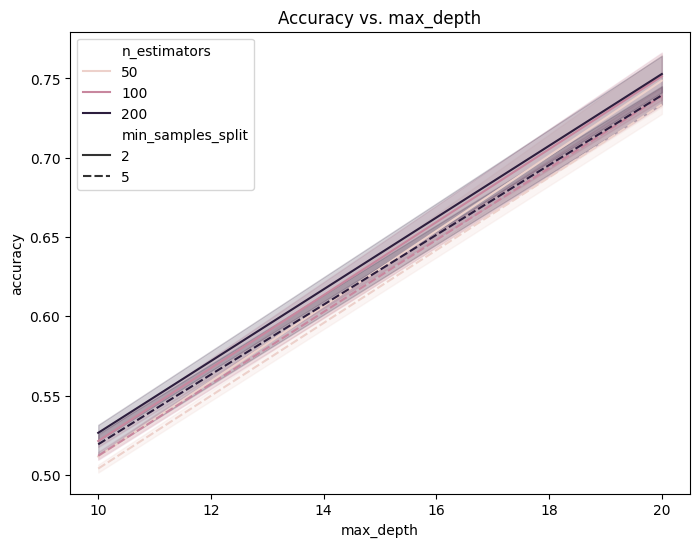

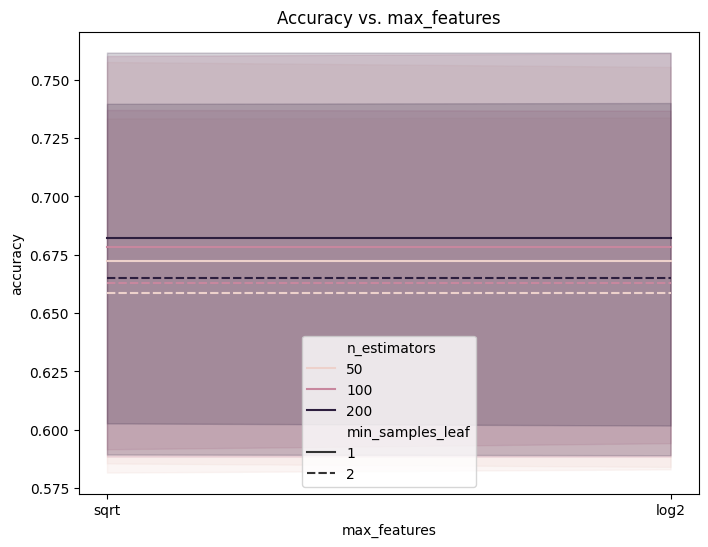


=== Experiments: Scaling=False, Imputation=median, Fraction=0.5 ===

Dataset size: 8988, Training samples: 7190, Testing samples: 1798

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])


Accuracy: 0.75, F1-Score: 0.70, ROC-AUC: 0.66, CV Accuracy: 0.75
Training Time: 0.83s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.72, F1-Score: 0.69, ROC-AUC: 0.66, CV Accuracy: 0.72
Training Time: 0.63s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.75, F1-Score: 0.70, ROC-AUC: 0.66, CV Accuracy: 0.75
Training Time: 0.74s, Prediction Time: 0.03s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.72, F1-Score: 0.69, ROC-AUC: 0.66, CV Accuracy: 0.72
Training Time: 0.62s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.73, F1-Score: 0.70, ROC-AUC: 0.66, CV Accuracy: 0.73
Training Time: 0.65s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None,

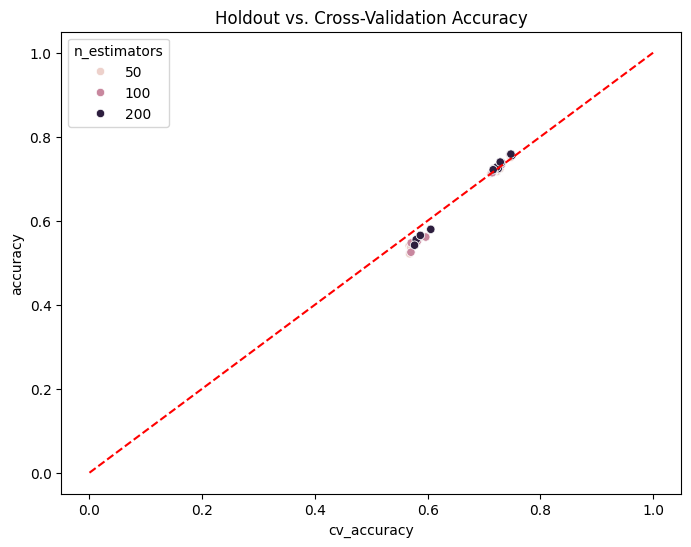


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.091876
100    0.091733
200    0.085781
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.016605
20.0    0.016215
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.088152
5    0.089963
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.089342
sqrt    0.089342
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.089720
2    0.087401
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
200    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    10
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    10
Name: count, dtype: int64


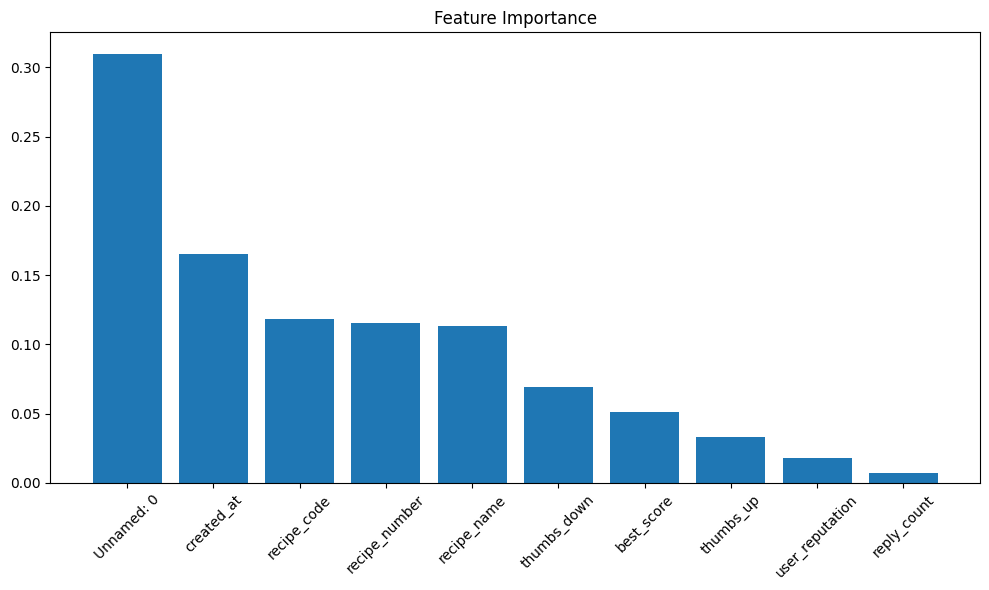

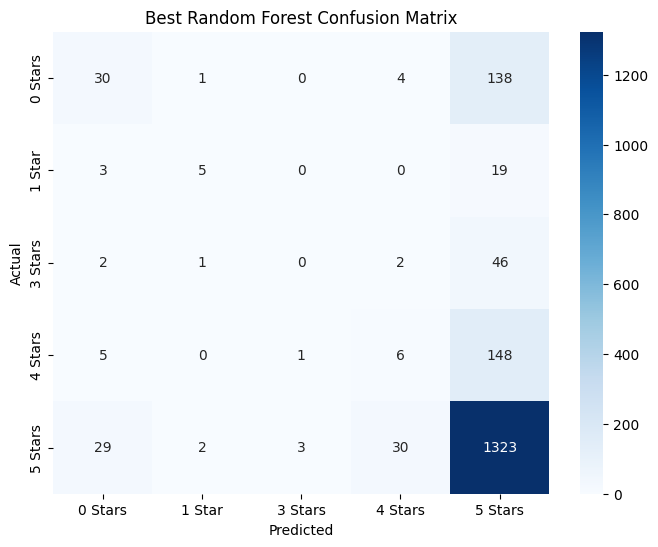


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.43      0.17      0.25       173
      1 Star       0.56      0.19      0.28        27
     3 Stars       0.00      0.00      0.00        51
     4 Stars       0.14      0.04      0.06       160
     5 Stars       0.79      0.95      0.86      1387

    accuracy                           0.76      1798
   macro avg       0.38      0.27      0.29      1798
weighted avg       0.67      0.76      0.70      1798



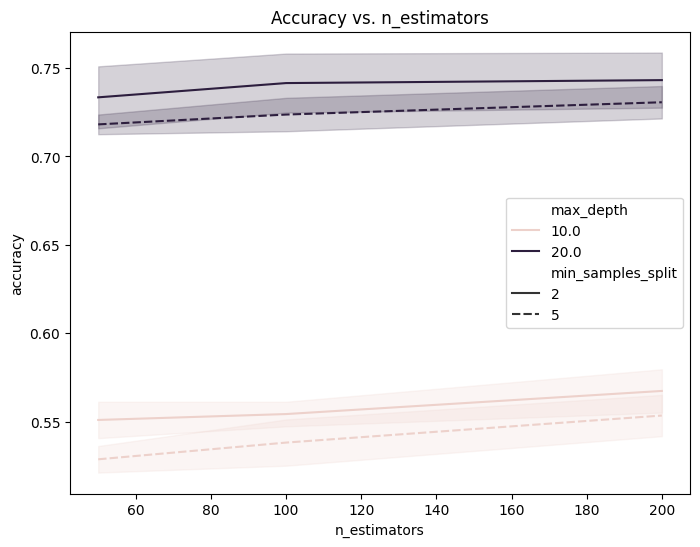

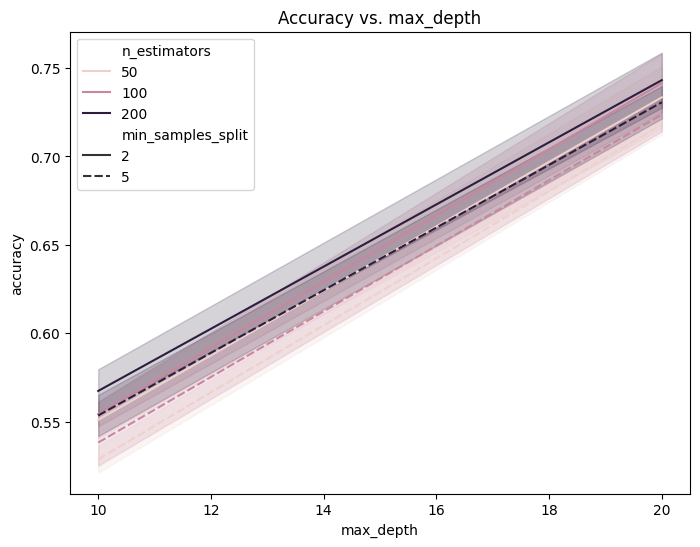

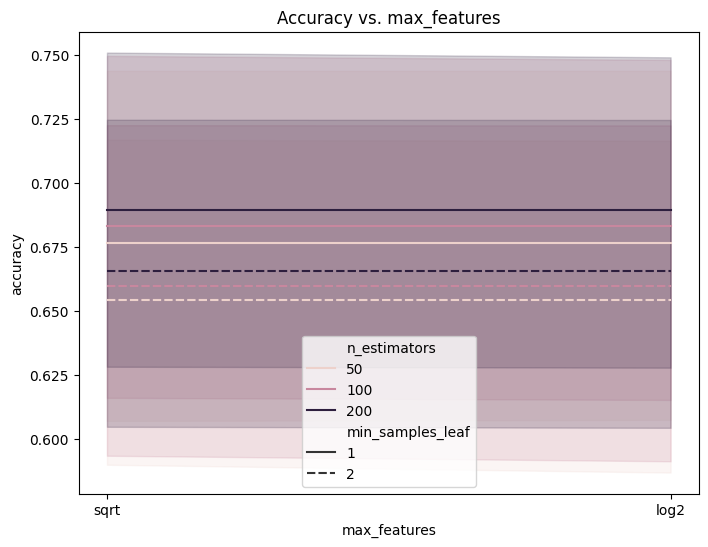


=== Experiments: Scaling=False, Imputation=median, Fraction=1.0 ===


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])



Dataset size: 17950, Training samples: 14360, Testing samples: 3590

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.74, F1-Score: 0.69, ROC-AUC: 0.66, CV Accuracy: 0.75
Training Time: 1.58s, Prediction Time: 0.07s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.71, F1-Score: 0.69, ROC-AUC: 0.67, CV Accuracy: 0.72
Training Time: 1.14s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.74, F1-Score: 0.69, ROC-AUC: 0.66, CV Accuracy: 0.75
Training Time: 1.83s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.71, F1-Score: 0.69, ROC-AUC: 0.67, CV Accuracy: 0.72
Training Time: 1.14s, Prediction Time: 0.05s

Testing: n_estimators=50, max_depth=None, min_s

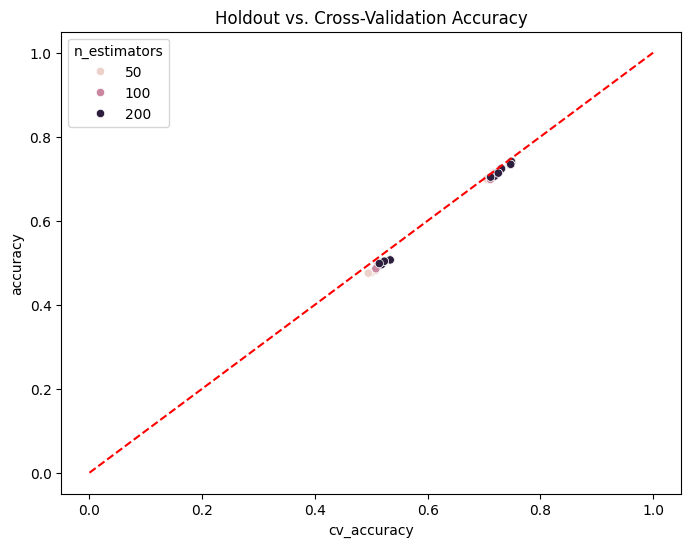


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.113336
100    0.107954
200    0.105114
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.009909
20.0    0.012897
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.109807
5    0.106184
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.108118
sqrt    0.108118
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.110462
2    0.105046
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
200    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    10
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    10
Name: count, dtype: int64


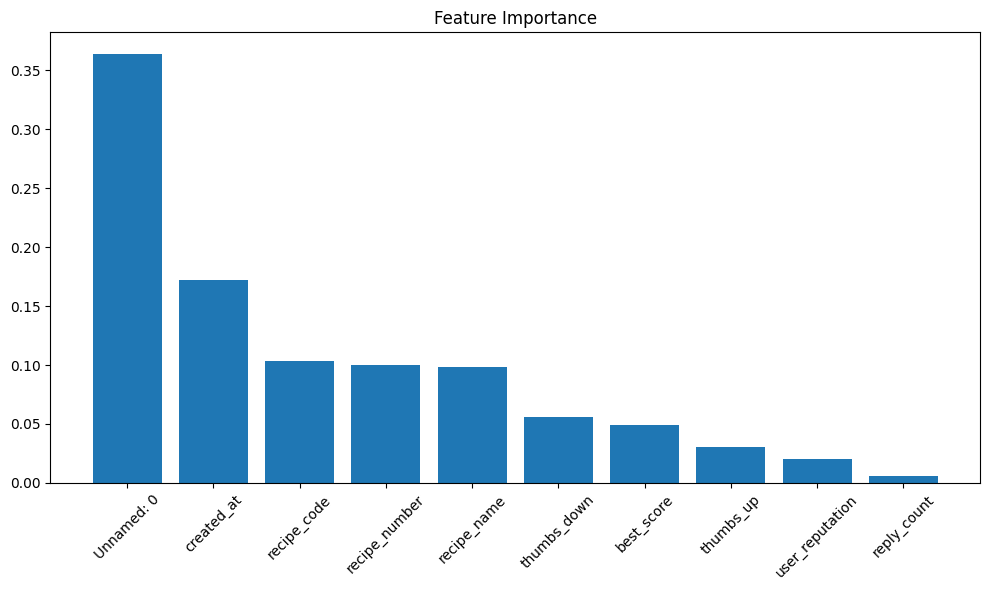

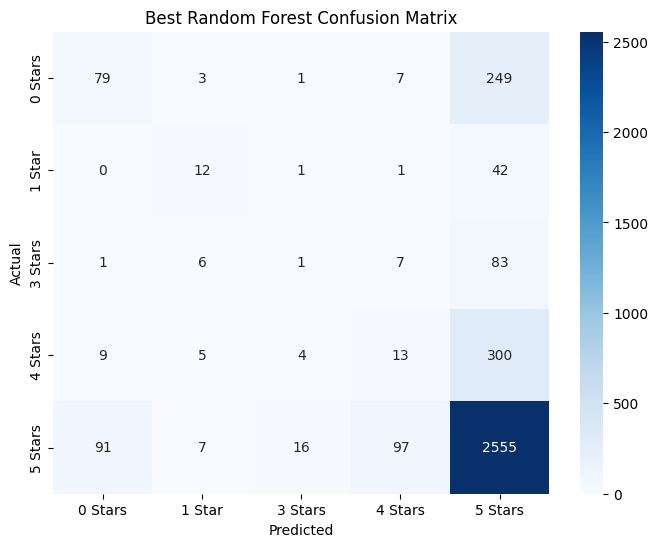


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.44      0.23      0.30       339
      1 Star       0.36      0.21      0.27        56
     3 Stars       0.04      0.01      0.02        98
     4 Stars       0.10      0.04      0.06       331
     5 Stars       0.79      0.92      0.85      2766

    accuracy                           0.74      3590
   macro avg       0.35      0.28      0.30      3590
weighted avg       0.67      0.74      0.70      3590



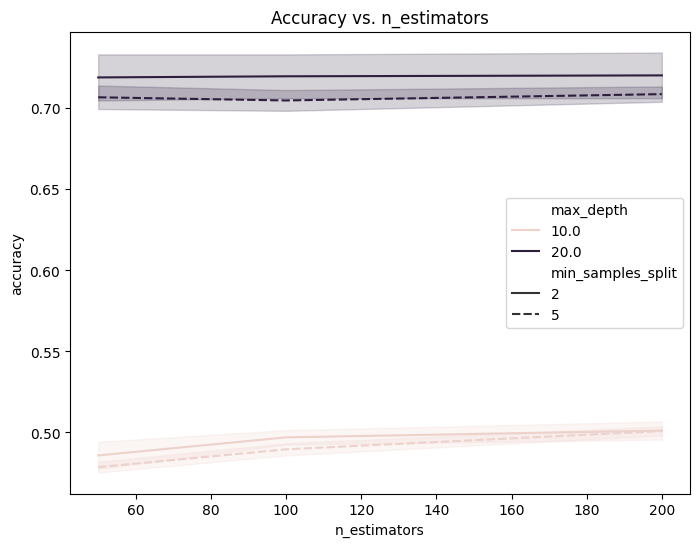

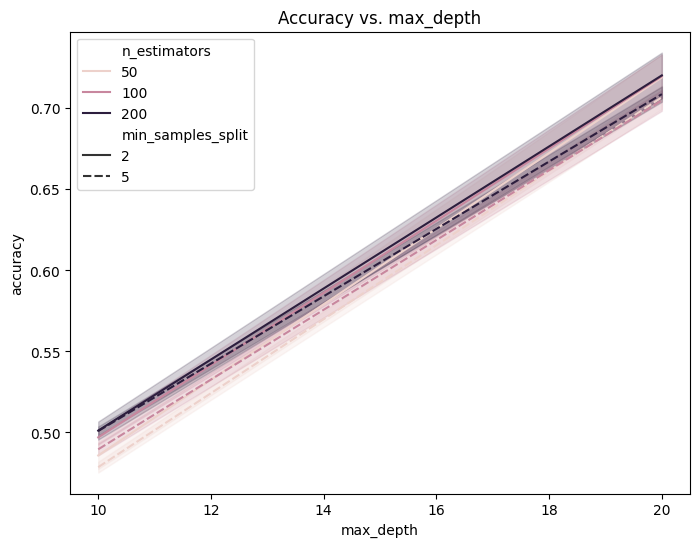

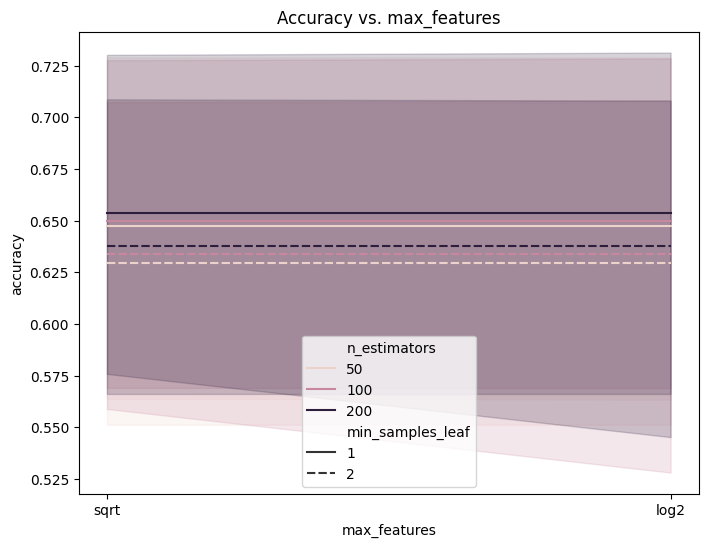


=== Experiments: Scaling=False, Imputation=mean, Fraction=0.5 ===

Dataset size: 8988, Training samples: 7190, Testing samples: 1798

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])


Accuracy: 0.76, F1-Score: 0.70, ROC-AUC: 0.67, CV Accuracy: 0.75
Training Time: 0.88s, Prediction Time: 0.03s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.72, F1-Score: 0.69, ROC-AUC: 0.66, CV Accuracy: 0.72
Training Time: 0.66s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.76, F1-Score: 0.70, ROC-AUC: 0.67, CV Accuracy: 0.75
Training Time: 0.73s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.72, F1-Score: 0.69, ROC-AUC: 0.66, CV Accuracy: 0.72
Training Time: 0.63s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.73, F1-Score: 0.69, ROC-AUC: 0.67, CV Accuracy: 0.73
Training Time: 0.63s, Prediction Time: 0.02s

Testing: n_estimators=50, max_depth=None,

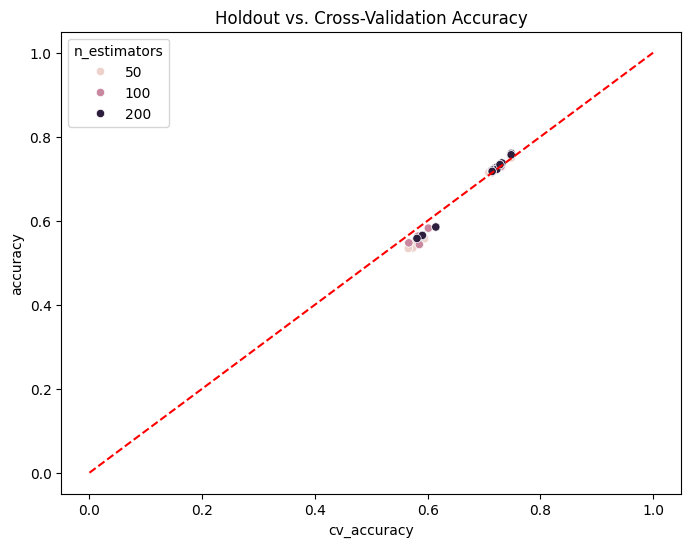


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.089434
100    0.084978
200    0.081503
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.015898
20.0    0.015290
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.087067
5    0.082200
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.084918
sqrt    0.084918
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.085196
2    0.083074
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
200    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    10
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    10
Name: count, dtype: int64


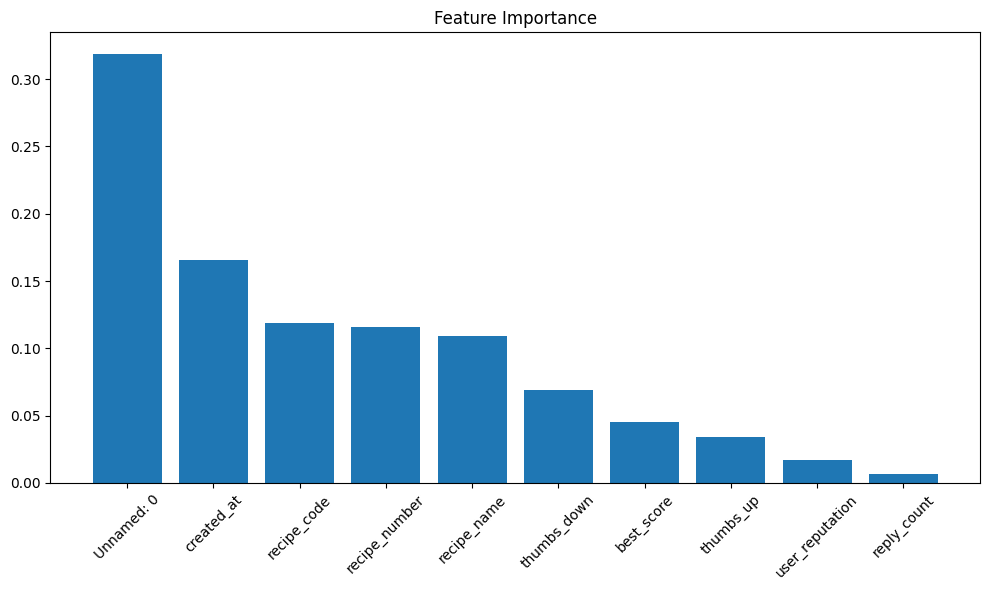

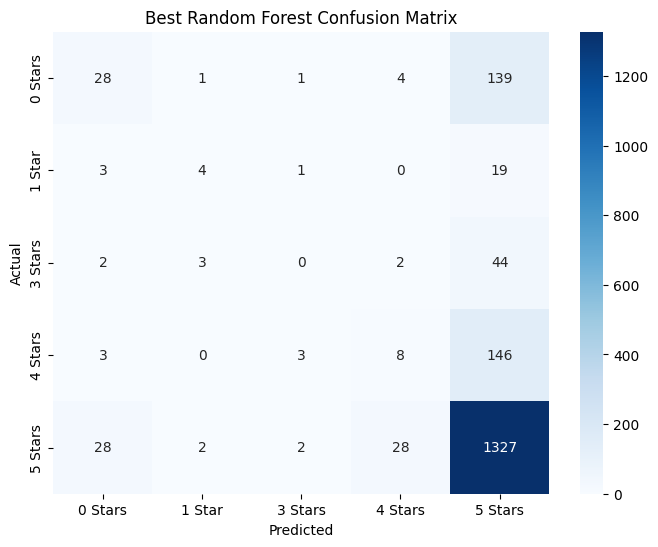


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.44      0.16      0.24       173
      1 Star       0.40      0.15      0.22        27
     3 Stars       0.00      0.00      0.00        51
     4 Stars       0.19      0.05      0.08       160
     5 Stars       0.79      0.96      0.87      1387

    accuracy                           0.76      1798
   macro avg       0.36      0.26      0.28      1798
weighted avg       0.68      0.76      0.70      1798



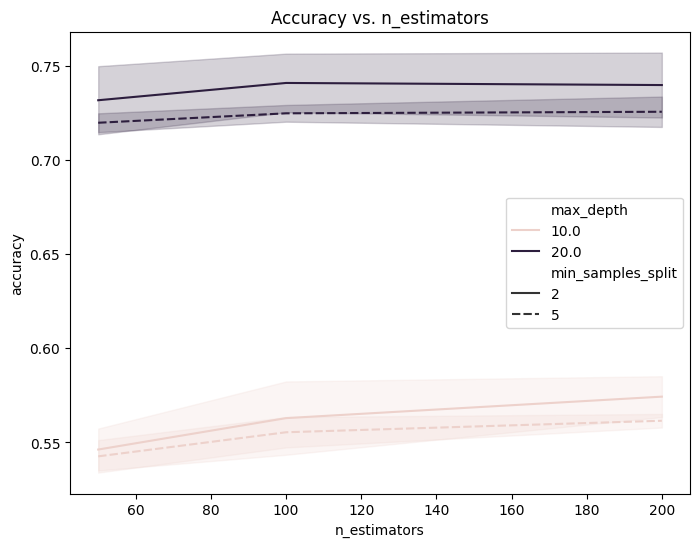

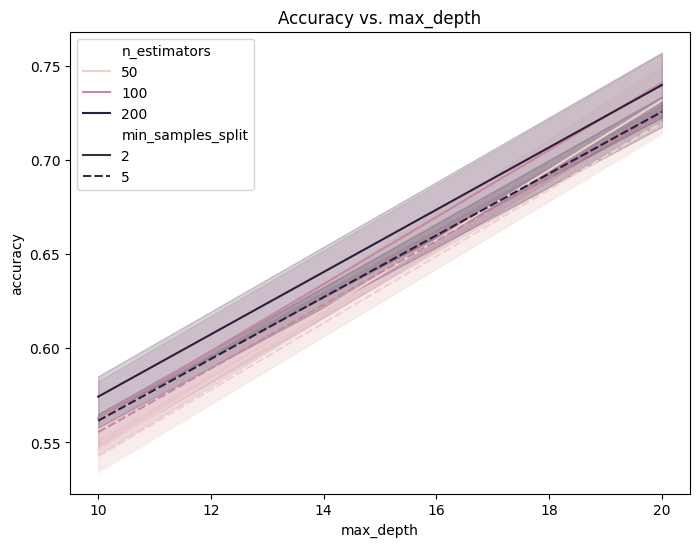

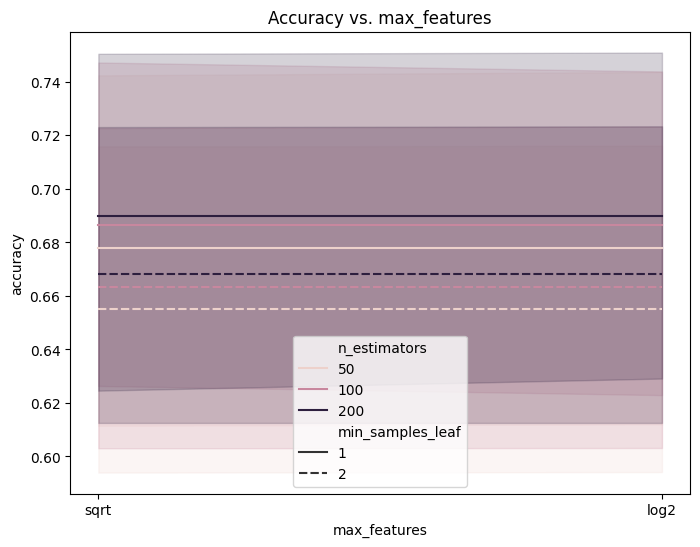


=== Experiments: Scaling=False, Imputation=mean, Fraction=1.0 ===


/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/4y/rcqh5h6941d8_km_12_j1kd80000gq/T/ipykernel_1516/252330012.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])



Dataset size: 17950, Training samples: 14360, Testing samples: 3590

=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.74, F1-Score: 0.69, ROC-AUC: 0.67, CV Accuracy: 0.75
Training Time: 2.15s, Prediction Time: 0.07s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.71, F1-Score: 0.69, ROC-AUC: 0.68, CV Accuracy: 0.72
Training Time: 1.82s, Prediction Time: 0.07s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.74, F1-Score: 0.69, ROC-AUC: 0.67, CV Accuracy: 0.75
Training Time: 2.14s, Prediction Time: 0.07s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.71, F1-Score: 0.69, ROC-AUC: 0.68, CV Accuracy: 0.72
Training Time: 1.66s, Prediction Time: 0.12s

Testing: n_estimators=50, max_depth=None, min_s

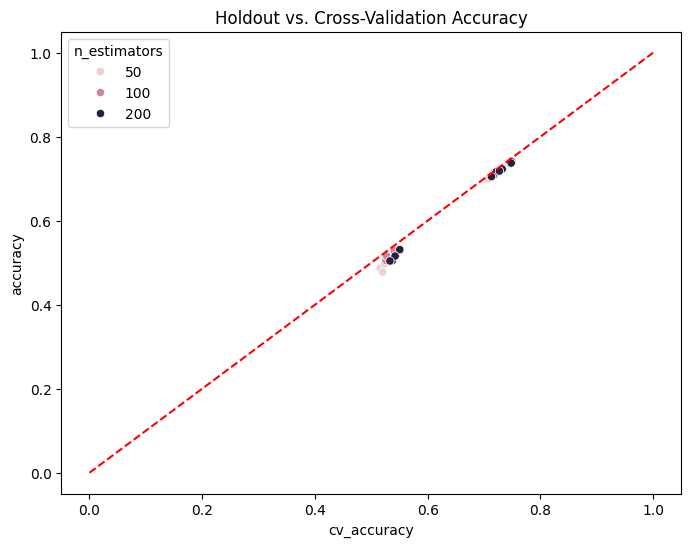


Parameter Sensitivity (Std of Accuracy):
n_estimators:
n_estimators
50     0.109099
100    0.099849
200    0.100348
Name: accuracy, dtype: float64
max_depth:
max_depth
10.0    0.014954
20.0    0.012785
Name: accuracy, dtype: float64
min_samples_split:
min_samples_split
2    0.104040
5    0.100706
Name: accuracy, dtype: float64
max_features:
max_features
log2    0.10255
sqrt    0.10255
Name: accuracy, dtype: float64
min_samples_leaf:
min_samples_leaf
1    0.103021
2    0.101239
Name: accuracy, dtype: float64

Most Common Parameters in Top 10 Models:
n_estimators: n_estimators
100    4
Name: count, dtype: int64
max_depth: max_depth
20.0    4
Name: count, dtype: int64
min_samples_split: min_samples_split
2    10
Name: count, dtype: int64
max_features: max_features
sqrt    5
Name: count, dtype: int64
min_samples_leaf: min_samples_leaf
1    10
Name: count, dtype: int64


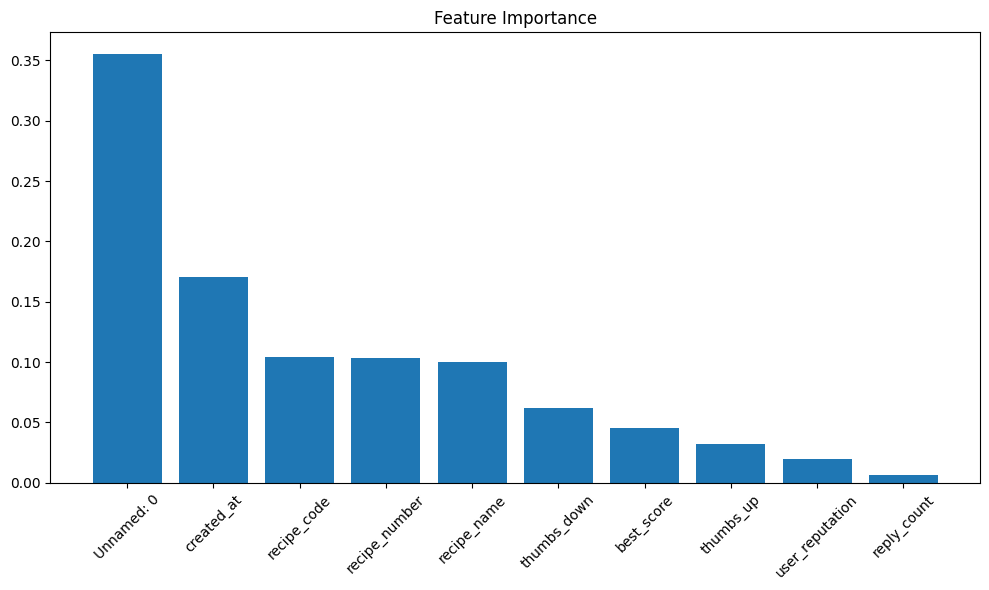

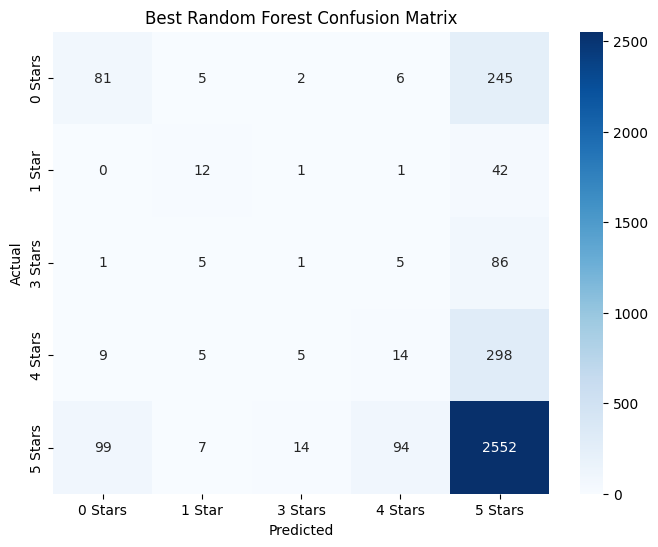


Classification Report for Best Model:
              precision    recall  f1-score   support

     0 Stars       0.43      0.24      0.31       339
      1 Star       0.35      0.21      0.27        56
     3 Stars       0.04      0.01      0.02        98
     4 Stars       0.12      0.04      0.06       331
     5 Stars       0.79      0.92      0.85      2766

    accuracy                           0.74      3590
   macro avg       0.35      0.29      0.30      3590
weighted avg       0.67      0.74      0.70      3590



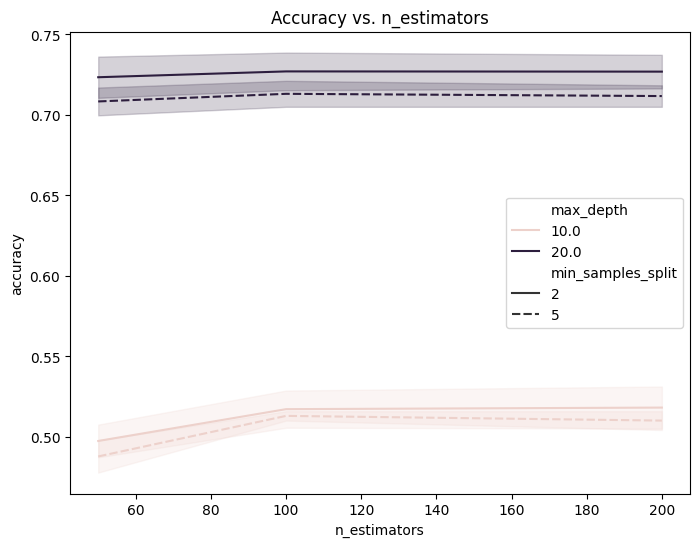

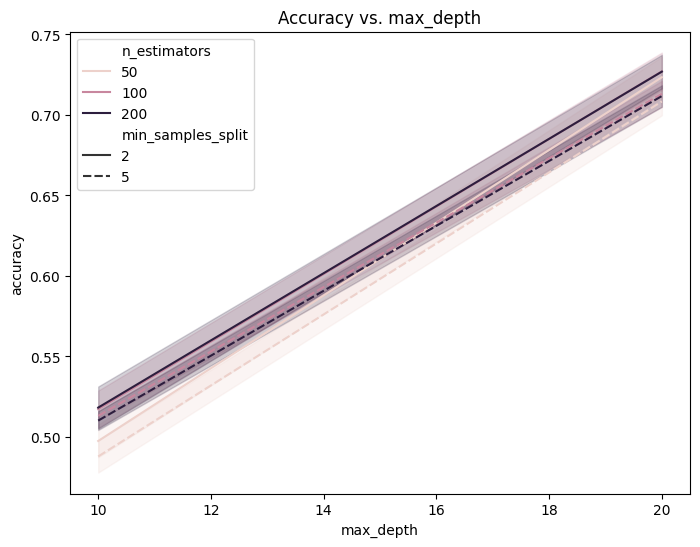

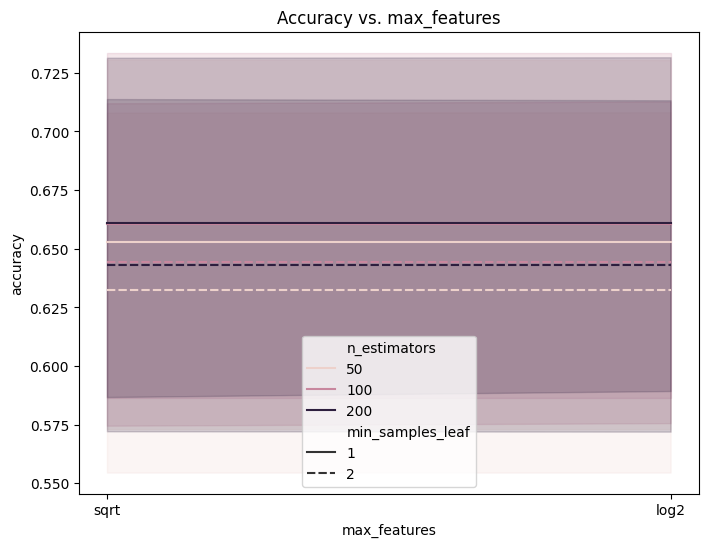

In [7]:
# Cell 6: Main Execution
# Define class names dynamically based on unique values in y
X_train, X_test, y_train, y_test, y, feature_cols = preprocess_data(df)  # Initial preprocessing to get y
class_names = [f"{int(label)} Star{'s' if label != 1 else ''}" for label in sorted(y.unique())]
print("Class names:", class_names)

# Run experiments for different dataset sizes, scaling, and imputation strategies
for scaling in [True, False]:
    for imputation_strategy in ['median', 'mean']:
        for frac in [0.5, 1.0]:
            print(f"\n=== Experiments: Scaling={scaling}, Imputation={imputation_strategy}, Fraction={frac} ===")
            X_train, X_test, y_train, y_test, y, feature_cols = preprocess_data(
                df, scaling=scaling, imputation_strategy=imputation_strategy, sample_fraction=frac
            )
            results = run_rf_experiments(X_train, y_train, X_test, y_test, class_names, feature_cols)
            visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names, feature_cols)
            results_df = pd.DataFrame(results)
            results_df.to_csv(f"rf_results_recipe_scaling_{scaling}_imputation_{imputation_strategy}_frac_{frac}.csv", index=False)